In [ ]:
#@title
"""import json
from keras.utils.data_utils import get_file
from keras import backend as K

CLASS_INDEX = None
CLASS_INDEX_PATH = 'https://s3.amazonaws.com/deep-learning-models/image-models/imagenet_class_index.json'


def preprocess_input(x, dim_ordering='default'):
    if dim_ordering == 'default':
        dim_ordering = K.set_image_data_format('channels_first')
    assert dim_ordering in {'tf', 'th'}

    if dim_ordering == 'th':
        x[:, 0, :, :] -= 103.939
        x[:, 1, :, :] -= 116.779
        x[:, 2, :, :] -= 123.68
        # 'RGB'->'BGR'
        x = x[:, ::-1, :, :]
    else:
        x[:, :, :, 0] -= 103.939
        x[:, :, :, 1] -= 116.779
        x[:, :, :, 2] -= 123.68
        # 'RGB'->'BGR'
        x = x[:, :, :, ::-1]
    return x


def decode_predictions(preds, top=5):
    global CLASS_INDEX
    if len(preds.shape) != 2 or preds.shape[1] != 1000:
        raise ValueError('`decode_predictions` expects '
                         'a batch of predictions '
                         '(i.e. a 2D array of shape (samples, 1000)). '
                         'Found array with shape: ' + str(preds.shape))
    if CLASS_INDEX is None:
        fpath = get_file('imagenet_class_index.json',
                         CLASS_INDEX_PATH,
                         cache_subdir='models')
        CLASS_INDEX = json.load(open(fpath))
    results = []
    for pred in preds:
        top_indices = pred.argsort()[-top:][::-1]
        result = [tuple(CLASS_INDEX[str(i)]) + (pred[i],) for i in top_indices]
        results.append(result)
    return results"""

"import json\nfrom keras.utils.data_utils import get_file\nfrom keras import backend as K\n\nCLASS_INDEX = None\nCLASS_INDEX_PATH = 'https://s3.amazonaws.com/deep-learning-models/image-models/imagenet_class_index.json'\n\n\ndef preprocess_input(x, dim_ordering='default'):\n    if dim_ordering == 'default':\n        dim_ordering = K.set_image_data_format('channels_first')\n    assert dim_ordering in {'tf', 'th'}\n\n    if dim_ordering == 'th':\n        x[:, 0, :, :] -= 103.939\n        x[:, 1, :, :] -= 116.779\n        x[:, 2, :, :] -= 123.68\n        # 'RGB'->'BGR'\n        x = x[:, ::-1, :, :]\n    else:\n        x[:, :, :, 0] -= 103.939\n        x[:, :, :, 1] -= 116.779\n        x[:, :, :, 2] -= 123.68\n        # 'RGB'->'BGR'\n        x = x[:, :, :, ::-1]\n    return x\n\n\ndef decode_predictions(preds, top=5):\n    global CLASS_INDEX\n    if len(preds.shape) != 2 or preds.shape[1] != 1000:\n        raise ValueError('`decode_predictions` expects '\n                         'a batch o

## Import Packages

In [1]:
import skimage
import cv2
import os
import numpy as np
from sklearn import manifold, datasets
import pickle as pkl

import keras
from keras.preprocessing import image
from keras.models import Model
from keras.applications.vgg19 import VGG19
from skimage.transform import resize
#import imagenet_utils as imu
from keras.applications import imagenet_utils as imu

import tensorflow as tf
from tensorflow.keras.applications import VGG19
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg19 import preprocess_input
from tensorflow.keras.models import Model

import matplotlib.pyplot as plt

In [2]:
import cv2 as cv
from glob import glob
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Load Data

In [3]:
PATH = '/content/drive/My Drive/images/latent_space_sm/' #@param{type:'string'}

#images = [cv.imread(file, cv.COLOR_BGR2RGB) for file in glob(PATH + '/*.jpg')]
#print(len(images))

In [ ]:
#@title
"""rootfolder = PATH
file_list = os.listdir(rootfolder)
print(file_list)"""

'rootfolder = PATH\nfile_list = os.listdir(rootfolder)\nprint(file_list)'

In [ ]:
#@title
"""file_list_sorted = file_list.sort()
print(file_list_sorted)"""

'file_list_sorted = file_list.sort()\nprint(file_list_sorted)'

In [ ]:
#@title
"""
#rootfolder = 'D:\\COMPUTER_VISION\\AAPR\\10000_imgs_aa_barrel_vault'
file_list = []
for i in range(len(os.listdir(rootfolder))):
  file_list.append(plt.imread(PATH + str(i+10000) + '.jpg'))

print(file_list)"""

"\n#rootfolder = 'D:\\COMPUTER_VISION\\AAPR\\10000_imgs_aa_barrel_vault'\nfile_list = []\nfor i in range(len(os.listdir(rootfolder))):\n  file_list.append(plt.imread(PATH + str(i+10000) + '.jpg'))\n\nprint(file_list)"

In [4]:
#np.array(file_list)

### Preview

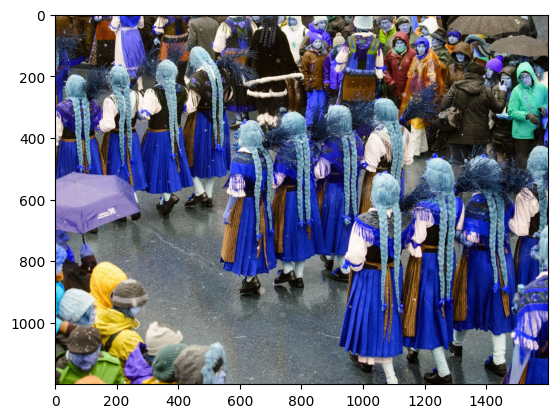

In [5]:
# Initialise the image stack with the first image
img = cv.imread(PATH + '1.jpg') # Mind the naming pattern
#print(img)
plt.imshow(img)

## PCA (principal component analysis)

In [6]:
import numpy as np
import matplotlib.pyplot as plt
import sklearn.decomposition as dp
import imageio
from skimage import io,transform,color
from skimage import img_as_ubyte
#from sklearn.datasets.base import load_iris
from PIL import Image
import cv2 as cv

In [7]:
num_imgs = 36 #@param{type:'integer'}

In [8]:
# Initialise im_stack as an empty list
im_stack = []

In [9]:
for i in range(1, num_imgs + 1):
    img = cv.imread(PATH + str(i) + '.jpg')
    if img is not None:
        img_gray = color.rgb2gray(img)

        # Set the new size for the image
        new_size = (256, 256)

        # Resize the image
        img_gray = cv.resize(img_gray, new_size, interpolation=cv.INTER_AREA)

        # Flatten the image and append it to the stack
        im_stack.append(img_gray.flatten())

# Convert im_stack to a NumPy array
im_stack = np.array(im_stack)

# Verify the shape of the image stack
assert im_stack.shape == (num_imgs, new_size[0] * new_size[1]), \
    "The shape of the image stack does not match the expected dimensions."

# Function to perform PCA on the image stack
def PCA(matrix, num_components=3):
    pca = dp.PCA(n_components=num_components)
    pca_features = pca.fit_transform(matrix)
    return pca_features

# Apply PCA to the image stack
low_matrix = PCA(im_stack)

# Display the PCA features for each image
for i, features in enumerate(low_matrix):
    print(f"Image {i+1} PCA features: {features}")

Image 1 PCA features: [ 13.96510389 -16.61543553  -9.56115833]
Image 2 PCA features: [  1.17431527  -6.38064081 -11.92600206]
Image 3 PCA features: [-19.59822582 -34.20220618  22.90841496]
Image 4 PCA features: [-20.72884379 -27.72877784  -5.78729796]
Image 5 PCA features: [12.52335216 -6.88768114  1.60197685]
Image 6 PCA features: [-43.6883511   -0.52108306   3.19539778]
Image 7 PCA features: [-12.44828228 -13.25434779   9.49358671]
Image 8 PCA features: [ 30.03451553 -17.15290434 -28.19157673]
Image 9 PCA features: [-27.69066883   1.01463326   0.85804   ]
Image 10 PCA features: [25.3527245  14.66422184 31.54309276]
Image 11 PCA features: [-20.76559355   3.49725502  27.58190081]
Image 12 PCA features: [ 7.87407057 17.19668543  2.29976617]
Image 13 PCA features: [ 6.43979947 32.83196475  4.00816825]
Image 14 PCA features: [13.54993421  7.9619804  -8.26566993]
Image 15 PCA features: [20.01854295 -3.16888004  6.09459486]
Image 16 PCA features: [-4.08217776  1.73858236 -5.14859363]
Image 

In [10]:
def PCA(matrix, num_components=3):
    # Load the PCA algorithm, set the principal component after dimensionality reduction to num_components
    pca = dp.PCA(n_components=num_components)
    # Dimensionality reduction on raw data
    pca_features = pca.fit_transform(matrix)

    # Print the first two PCA features for brevity
    print(pca_features[0])
    print(pca_features[1])

    # Print PCA features for each image
    for i in range(num_imgs):
        print(f"Image {i+1} PCA features: {pca_features[i]}")

    return pca_features

# Apply PCA to the image stack
low_matrix = PCA(im_stack)


[ 13.9648516  -16.61891406  -9.36828866]
[  1.17420732  -6.37364523 -11.89164619]
Image 1 PCA features: [ 13.9648516  -16.61891406  -9.36828866]
Image 2 PCA features: [  1.17420732  -6.37364523 -11.89164619]
Image 3 PCA features: [-19.5984086  -34.201432    22.89644629]
Image 4 PCA features: [-20.72877585 -27.72675423  -5.77183546]
Image 5 PCA features: [12.52343526 -6.88827351  1.47568759]
Image 6 PCA features: [-43.68838634  -0.52096836   3.25202815]
Image 7 PCA features: [-12.44808953 -13.25341766   9.42080251]
Image 8 PCA features: [ 30.03462888 -17.1480771  -28.33665238]
Image 9 PCA features: [-27.69075133   1.0114136    0.78893425]
Image 10 PCA features: [25.35267385 14.66296429 31.52180268]
Image 11 PCA features: [-20.76546528   3.50288406  27.48599854]
Image 12 PCA features: [ 7.87419832 17.19521788  2.17804348]
Image 13 PCA features: [ 6.43961619 32.83741594  4.05030425]
Image 14 PCA features: [13.54998959  7.95987866 -8.27432411]
Image 15 PCA features: [20.01855309 -3.1750647

## T-SNE (t-distributed stochastic neighbor embedding)

In [11]:
import pickle as pkl
import numpy as np
import os
from sklearn import manifold, datasets
import time

_n_dim = 3
_perplexity = 10
_learning_rate = 100
_scale = 1

tsne = manifold.TSNE(n_components=_n_dim, init='pca', random_state=0, perplexity=int(_perplexity), learning_rate=int(_learning_rate))
X_tsne = tsne.fit_transform(low_matrix) # Fit X into an embedded space and return that transformed output.
X_tsne  = X_tsne *_scale
output = X_tsne.tolist()
time=time.time()

for i in range(num_imgs):
    print(output[i])


[-15.187111854553223, 80.95896911621094, -69.01885986328125]
[-36.89468002319336, 10.42111873626709, -29.744831085205078]
[16.261560440063477, -171.8218536376953, 29.40613555908203]
[6.353241443634033, -138.8297576904297, -23.58414077758789]
[-9.252270698547363, 73.47474670410156, -2.7694172859191895]
[128.01083374023438, -51.38322830200195, 59.51591491699219]
[105.8927001953125, 22.190168380737305, 12.553420066833496]
[29.013769149780273, 69.51727294921875, -108.46602630615234]
[95.18601989746094, -78.83744049072266, 25.97400665283203]
[-9.099462509155273, 109.25106048583984, 91.75688171386719]
[-127.84042358398438, -55.417755126953125, -60.3088493347168]
[-78.74566650390625, -14.949049949645996, 32.099403381347656]
[-74.58573150634766, -22.005155563354492, 81.48762512207031]
[-75.93667602539062, 51.751731872558594, 4.022056579589844]
[26.811241149902344, 111.78277587890625, 11.411870956420898]
[0.980334997177124, -14.417759895324707, 13.516077995300293]
[122.93180847167969, -39.93207

### Simple Visualisation

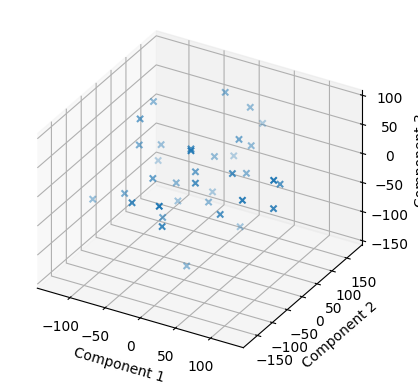

In [12]:
# Plotting the results in a 3D scatter plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Scatter plot without perspective (orthographic projection)
ax.scatter(X_tsne[:, 0], X_tsne[:, 1], X_tsne[:, 2], marker = 'x')
ax.set_proj_type('ortho')  # Setting orthographic projection

# Labeling axes
ax.set_xlabel('Component 1')
ax.set_ylabel('Component 2')
ax.set_zlabel('Component 3')

# Show the plot
plt.show()


[0.00176371 0.00176371 0.00176371 0.00176371 0.00176371 0.00176371
 0.00176371 0.00176371 0.00176371 0.00176371 0.00176371 0.00176371
 0.00176371 0.00176371 0.00176371 0.00176371 0.00176371 0.00176371
 0.00176371 0.00176371 0.00176371 0.00176371 0.00176371 0.00176371
 0.00176371 0.00176371 0.00176371 0.00176371 0.00176371 0.00176371
 0.00176371 0.00176371 0.00176371 0.00176371 0.00176371 0.00176371]


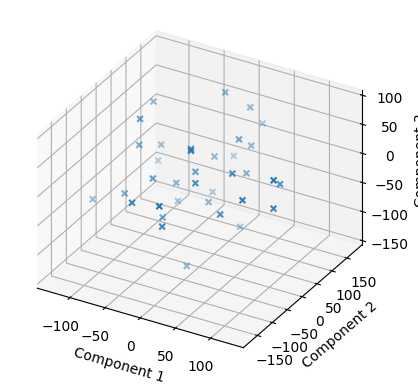

In [13]:
from sklearn.neighbors import KernelDensity
from mpl_toolkits.mplot3d import Axes3D

# Compute kernel density estimates for each point in the t-SNE data
kde = KernelDensity(bandwidth=1.0, kernel='gaussian')
kde.fit(X_tsne)
densities = kde.score_samples(X_tsne)  # Log density
densities = np.exp(densities)  # Convert log density to actual density
print(densities)

# Scale densities for marker sizes in the plot
density_scale = 10**4  # Scale factor for better visualisation
marker_sizes = densities * density_scale

# Creating the 3D scatter plot with marker sizes based on local kernel density
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Scatter plot without perspective, marker sizes based on density
scatter = ax.scatter(X_tsne[:, 0], X_tsne[:, 1], X_tsne[:, 2], marker='x', s=marker_sizes)

# Setting orthographic projection
ax.set_proj_type('ortho')

# Labeling axes
ax.set_xlabel('Component 1')
ax.set_ylabel('Component 2')
ax.set_zlabel('Component 3')

# Show the plot
plt.show()

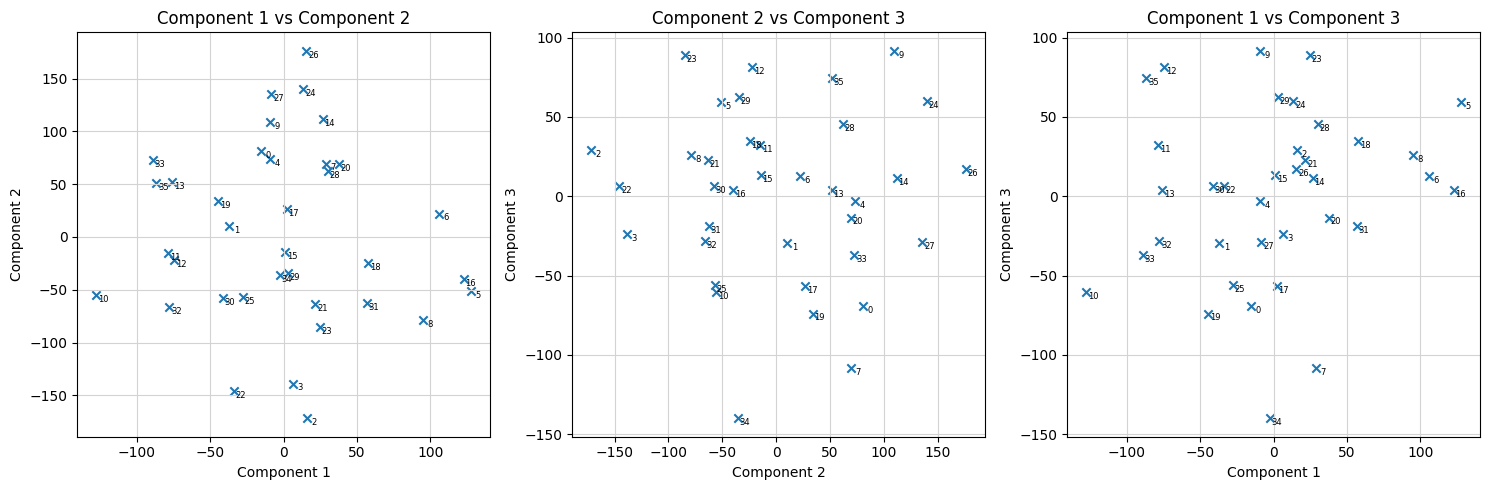

In [14]:
# Adjusting the annotation font size and adding gridlines to the scatter plots

# Re-creating the subplots with smaller font size for annotations and added gridlines
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

# Define a function for plotting and annotating with smaller font and gridlines
def plot_and_annotate(ax, x_data, y_data, title, xlabel, ylabel):
    ax.scatter(x_data, y_data, marker = 'x')
    ax.set_title(title)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.grid(True, color = 'lightgrey')  # Adding gridlines
    for i, (x, y) in enumerate(zip(x_data, y_data)):
        ax.annotate(i, (x, y), textcoords="offset points", xytext=(5,-5), ha='center', fontsize=6)  # Smaller font size

# Component 1 vs Component 2 with annotations
plot_and_annotate(axs[0], X_tsne[:, 0], X_tsne[:, 1], 'Component 1 vs Component 2', 'Component 1', 'Component 2')

# Component 2 vs Component 3 with annotations
plot_and_annotate(axs[1], X_tsne[:, 1], X_tsne[:, 2], 'Component 2 vs Component 3', 'Component 2', 'Component 3')

# Component 1 vs Component 3 with annotations
plot_and_annotate(axs[2], X_tsne[:, 0], X_tsne[:, 2], 'Component 1 vs Component 3', 'Component 1', 'Component 3')

# Display the annotated plots
plt.tight_layout()
plt.show()


[19.11804059 19.05579006  6.82219456  9.80974334 20.11449166  8.39712527
  6.24343233 18.63580398  8.88314648 18.31813378  5.30598038 14.78268485
 15.17302559 14.37031775 17.30967641 20.09131212  8.928837   19.61872564
 12.34453365 17.86338812 16.5878108  17.19425208  6.96086806 14.69309235
 15.37612416 17.42497092  9.08472314 15.13417915 18.10374796 20.02317734
 16.07311462 12.73261922 11.06793617 10.79348896 20.16588449 12.93245529]
[11.90086596 18.94173397  6.84722918  9.35371015 19.24666087 19.04722644
 22.45076387  6.68996262 20.92313585  6.76785817 12.56483988 24.87086878
 13.15201733 20.6520707  13.70127591 25.80543617 25.66452586 15.51814197
 25.12256163 12.83255087 19.4941819  24.09849304 10.63012766  8.48753513
  7.71929437 13.47046565  6.5044597   9.54293841 13.96459651 18.99200551
 24.70716177 20.55778661 18.53841512 17.04173553  3.59595758 10.27895097]
[21.95964147 30.5998106  39.63948618 34.87013352 39.59044001  8.90203226
 16.47741645  7.91888625 17.95544047 13.74180436 

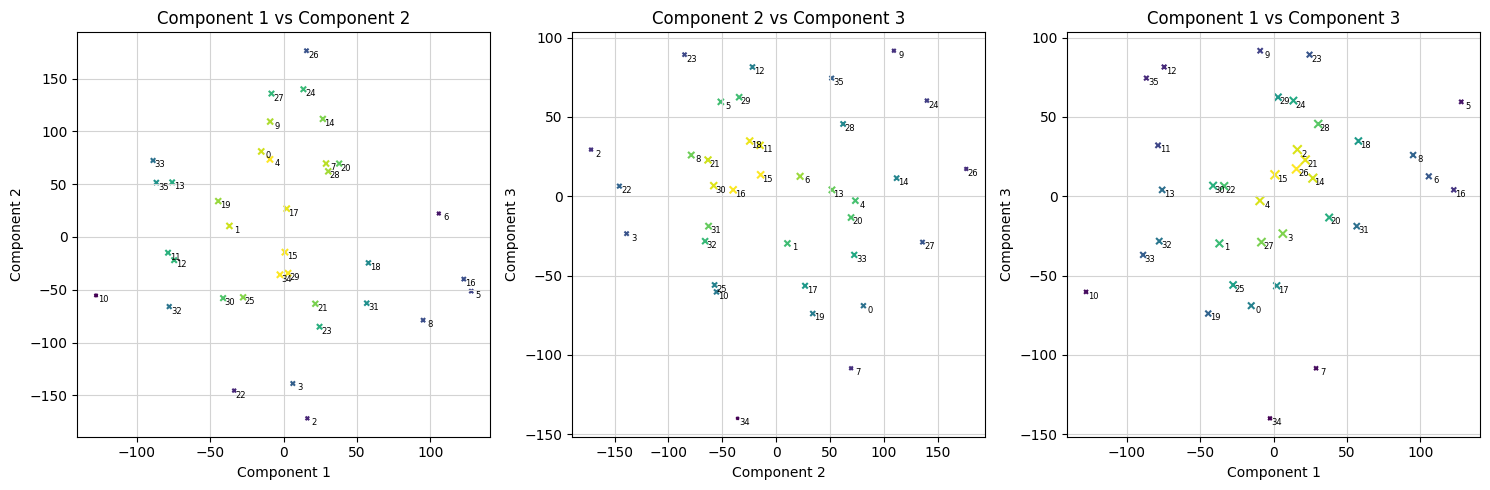

In [15]:
from scipy.stats import gaussian_kde

# Re-creating the subplots with density-based marker sizes
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

# Define a function for plotting and annotating with density-based marker sizes
def plot_and_annotate(ax, x_data, y_data, title, xlabel, ylabel):
    # Calculating the point density
    xy = np.vstack([x_data, y_data])
    scale = 10**6
    z = gaussian_kde(xy)(xy)*scale

    # Scatter plot with density-based marker sizes
    ax.scatter(x_data, y_data, s=z, marker='x', c=z)  # Scaling marker size by density
    ax.set_title(title)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.grid(True, color='lightgrey')  # Adding gridlines
    for i, (x, y) in enumerate(zip(x_data, y_data)):
        ax.annotate(i, (x, y), textcoords="offset points", xytext=(5,-5), ha='center', fontsize=6)  # Smaller font size
    print(z)

# Component 1 vs Component 2 with density-based marker sizes
plot_and_annotate(axs[0], X_tsne[:, 0], X_tsne[:, 1], 'Component 1 vs Component 2', 'Component 1', 'Component 2')

# Component 2 vs Component 3 with density-based marker sizes
plot_and_annotate(axs[1], X_tsne[:, 1], X_tsne[:, 2], 'Component 2 vs Component 3', 'Component 2', 'Component 3')

# Component 1 vs Component 3 with density-based marker sizes
plot_and_annotate(axs[2], X_tsne[:, 0], X_tsne[:, 2], 'Component 1 vs Component 3', 'Component 1', 'Component 3')

# Display the annotated plots
plt.tight_layout()
plt.show()


## Save CSV

In [16]:
# Convert the list to an array
my_array = np.array(output)

# Save the array as a CSV file
f_name = 'Latent_codes_carnival' #@param{type:'string'}
np.savetxt(f_name + '.csv', my_array, delimiter=',')

## Save Model

In [ ]:
"""
from pathlib import Path
features = np.stack(low_matrix, axis=0)

# rootfolder2 = Path + '_features'
rootfolder2 = '/content/drive/My Drive/'
fileName = os.path.join(rootfolder2,'pca_pool')
fileObject = open(fileName, 'wb')
pkl.dump(features, fileObject)
fileObject.close()
"""